# Unbuffered backtest

In [1]:
# Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf   # falls back to sample cov below

EXCHANGE_NAME = 'binance' 

path = "C:/Users/itataurov/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"

df = pd.read_parquet(path)
df = df.sort_values(by=['datetime'])
first_idx = df['fundingRate'].first_valid_index() # important to see when stuff began trading
df = df.loc[first_idx:]
df = df[df.datetime>'2021-01-01']
df = df[df.datetime<'2025-01-01']

In [2]:
df.columns

Index(['symbol', 'datetime', 'open', 'high', 'low', 'close', 'volume',
       'mkt_cap', 'fundingRate', 'oi', 'ls_ratio', 'longs_pct',
       'buy_volume_perp', 'total_volume_perp', 'buy_trades_perp',
       'total_trades_perp', 'spot_close', 'buy_volume_spot',
       'total_volume_spot', 'buy_trades_spot', 'total_trades_spot',
       'predicted_funding_rate'],
      dtype='object')

In [3]:
# Constants
trading_cost_rate = 15e-4

# filter backtest after filter_date
post_date = True
filter_date = '2022-01-01'

weight_inertia = 0
vol_target_bool = False
vol_target_ann=0.20
cov_lookback=90

#print parameters
print(f"Exchange: {EXCHANGE_NAME}")


Exchange: binance


In [4]:
def winsorize(x, lower_pct, upper_pct):
	lo, hi = x.quantile(lower_pct), x.quantile(upper_pct)
	return x.clip(lower=lo, upper=hi)

def compute_bolmom(df_filtered: pd.DataFrame) -> pd.DataFrame:
	print("Computing Bollinger Band momentum signal...")
	df_filtered = df_filtered.sort_values(['datetime', 'symbol'])

	# Calculate rolling volatility (same as used in Bollinger Bands)
	df_filtered['vol_ewm'] = df_filtered.groupby('symbol')['close'].transform(lambda x: x.ewm(span=100).std())

	# Calculate middle band (EMA)
	df_filtered['middle_band'] = df_filtered.groupby('symbol')['close'].transform(lambda x: x.ewm(span=100).mean())

	# Calculate distance to band (number of band widths away from middle)
	df_filtered['bollinger_distance'] = (df_filtered['close'] - df_filtered['middle_band']) / (2 * df_filtered['vol_ewm'])

	# Clipping for outliers/overextension
	df_filtered['signal3'] = df_filtered['bollinger_distance'].clip(lower=-1, upper=1)

	# z score for consistent l1 and l2 penalties
	df_filtered['signal3'] = df_filtered.groupby('datetime')['signal3'].transform(lambda x: (x - x.mean()) / x.std())

	return df_filtered

# Signal generation
def compute_signal(df: pd.DataFrame) -> pd.DataFrame:
	lookback = 32
	df['buy_volume_perp_slowed'] = df.groupby('symbol')['buy_volume_perp'].transform(
		lambda x: x.ewm(span=lookback).mean()
	)
	df['total_volume_perp_slowed'] = df.groupby('symbol')['total_volume_perp'].transform(
		lambda x: x.ewm(span=lookback).mean()
	)
	df['signal'] = df['buy_volume_perp_slowed'] / df['total_volume_perp_slowed']

	df['signal2'] = df.groupby('symbol')['longs_pct'].transform(
		lambda x: x.ewm(span=lookback).mean()
	)

	df = compute_bolmom(df)	

	df['signal'] = (
		df
		.groupby('datetime')['signal']
		.transform(lambda x: winsorize(x, 0.05, 0.95))
	)
	return df

# ── Universe filtering ──────────────────────────────────────────────────────
def filter_universe(df: pd.DataFrame) -> pd.DataFrame:
	"""
	Filter out illiquids and newly listed coins.
	"""

	df = df[df.dollar_volume_slowed >= 1e6] # at least $1M daily volume 
	df = df[df.days_since_listing >= 90] # at least 90 days since listing (need data for risk estimate)
	return df

# Data preparation
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
	df = df.sort_values(['datetime', 'symbol'])
	df['return'] = df.groupby('symbol')['close'].transform(lambda x: x.pct_change())

	# 1) Calculate volatility
	df['vol_expanding_window'] = (
		df.groupby('symbol')['return']
		  .transform(lambda x: x
					  .expanding(min_periods=30)
					  .std())
	)
	df['vol_ewm'] = (
		df.groupby('symbol')['return']
		  .transform(lambda x: x
					  .ewm(span=30, adjust=False, min_periods=30)
					  .std())
	)
	df['volatility'] = (
		df['vol_expanding_window'] * 0.25 +
		df['vol_ewm'] * 0.75
	)

	# 2) filter universe
	df['dollar_volume'] = df['close'] * df['volume']
	df['dollar_volume_slowed'] = (
		df.groupby('symbol')['dollar_volume']
		  .transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
	)
	df['dv_rank'] = (
		df.groupby('datetime')['dollar_volume_slowed']
		  .rank(method='first', ascending=False)
	)
	df['dv_decile'] = df.groupby('datetime')['dollar_volume_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

	df['market_cap_slowed'] = (
	df.groupby('symbol')['mkt_cap']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
	)
	df['mc_rank'] = (
		df.groupby('datetime')['market_cap_slowed']
			.rank(method='first', ascending=False)
	)
	df['mc_decile'] = df.groupby('datetime')['market_cap_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

	# 1) how many observations each symbol has accumulated up to *and incl.* the row
	df['days_since_listing'] = df.groupby('symbol').cumcount() + 1

	return df

# TODO: Add funding returns to target 
def add_prediction_target(df: pd.DataFrame) -> pd.DataFrame:
	df = df.copy()
	df = df.sort_values(['datetime'])
	# raw signal	
	df['10d_forward_price'] = df.groupby('symbol')['close'].shift(-10)
	df['10d_return'] = (df['10d_forward_price'] - df['close']) / df['close']
	# demean within each date
	df['target'] = df.groupby('datetime')['10d_return'].transform(lambda x: x - x.mean())
	return df.drop(columns=['10d_forward_price', '10d_return'])


print("Preparing data...")
df = prepare_data(df)

print("Computing signal...")
df = compute_signal(df)

print("Filtering universe...")
df = filter_universe(df)

print("Adding prediction target...")
df = add_prediction_target(df)

df


Preparing data...
Computing signal...
Computing Bollinger Band momentum signal...
Filtering universe...
Adding prediction target...


,symbol,datetime,open,high,low,close,volume,mkt_cap,fundingRate,oi,...,mc_decile,days_since_listing,buy_volume_perp_slowed,total_volume_perp_slowed,signal,signal2,middle_band,bollinger_distance,signal3,target
20311,1INCH,2021-04-01,4.344400,4.533900,4.253700,4.460600,14490755.0,NaN,0.003538,NaN,...,NaN,90,1.143031e+07,2.469443e+07,0.462870,84.997705,4.023428,0.202493,-0.704371,0.099445
20381,SNX,2021-04-01,17.693000,19.431000,17.632000,19.206000,2782391.5,2.411015e+09,0.004446,NaN,...,7.0,90,9.684540e+05,2.044175e+06,0.473763,76.615812,19.130788,0.011657,-1.230192,-0.183622
20380,SKL,2021-04-01,0.752120,0.824600,0.720000,0.816680,106781335.0,4.606508e+08,0.004734,NaN,...,2.0,90,7.008064e+07,1.471926e+08,0.476115,73.315235,0.440883,0.724568,0.734127,-0.319714
20376,RUNE,2021-04-01,7.959600,8.955000,7.957900,8.340300,8303806.0,0.000000e+00,0.002288,NaN,...,1.0,90,3.295036e+06,7.022799e+06,0.469191,68.950112,4.908900,1.077563,1.493038,0.149518
20375,RSR,2021-04-01,0.090032,0.091795,0.084801,0.088243,467587452.0,3.706845e+08,0.004858,NaN,...,3.0,90,4.337915e+08,9.267911e+08,0.468058,77.878756,0.064288,0.631987,0.479034,-0.195028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262969,EGLD,2024-12-31,34.301000,35.179000,33.026000,33.437000,415161.8,4.518378e+08,0.000300,9.757355e+06,...,7.0,1460,3.568184e+05,7.477575e+05,0.477185,70.668491,35.309172,-0.104671,0.026351,NaN
262968,EDU,2024-12-31,0.530400,0.545700,0.518000,0.525700,10433287.0,NaN,0.000300,5.918918e+06,...,NaN,612,1.160723e+07,2.479929e+07,0.475340,74.329599,0.576849,-0.321057,-0.657202,NaN
262967,DYM,2024-12-31,1.356100,1.398800,1.300500,1.322600,5957093.4,2.548972e+08,0.000300,7.250934e+06,...,6.0,329,6.125189e+06,1.286328e+07,0.476176,77.359048,1.780250,-0.466211,-1.115739,NaN
262939,CHR,2024-12-31,0.238900,0.241500,0.222700,0.232300,58700697.0,1.934000e+08,0.000283,4.443076e+06,...,5.0,1391,3.541274e+07,7.410246e+07,0.477889,69.533266,0.238428,-0.054886,0.183619,NaN


# OLS forecast


In [5]:
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def calculate_vif(X, feature_cols):
    """
    Calculate Variance Inflation Factor (VIF) for each feature in the design matrix.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Design matrix (including intercept as first column).
    feature_cols : list
        Names of features (excluding intercept).

    Returns
    -------
    vif : pd.Series
        VIF values indexed by feature names.
    """
    vif_data = {}
    X = np.asarray(X)
    n_features = X.shape[1] - 1  # Exclude intercept
    
    for j in range(1, n_features + 1):  # Skip intercept (first column)
        # Features excluding the j-th feature
        mask = np.ones(n_features + 1, dtype=bool)
        mask[j] = False
        X_others = X[:, mask]
        X_j = X[:, j]
        
        # Regress feature j against other features
        model = LinearRegression()
        model.fit(X_others, X_j)
        yhat_j = model.predict(X_others)
        
        # Compute R² and VIF
        r2 = r2_score(X_j, yhat_j)
        vif = 1.0 / (1.0 - r2) if r2 < 1.0 else np.inf
        
        vif_data[feature_cols[j - 1]] = vif
    
    return pd.Series(vif_data)

def kfold_cv_metrics(X, y, k=5, random_state=42, n_jobs=None):
    """
    K-fold cross-validation for linear OLS with multithreading using cross_val_score.
    Returns (mse, r2) averaged over folds.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Feature matrix.
    y : array-like of shape (n_samples,)
        Target vector.
    k : int, default=5
        Number of folds for cross-validation.
    random_state : int, default=42
        Random seed for reproducibility.
    n_jobs : int, optional
        Number of parallel jobs for cross-validation. If None, uses one job (no parallelism).

    Returns
    -------
    mse : float
        Average mean squared error across folds.
    r2 : float
        Average R² score across folds.
    """
    n = len(y)
    if n < k:
        return np.nan, np.nan

    # Initialize model and KFold
    model = LinearRegression()
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

    # Compute MSE and R² scores using cross_val_score
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=n_jobs)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2', n_jobs=n_jobs)

    # Convert negative MSE to positive and compute averages
    mse = float(-np.mean(mse_scores))
    r2 = float(np.nanmean(r2_scores))

    return mse, r2

def walkforward_cs_ols(df,
                      feature_cols,
                      target_col="target",
                      lookback=180,
                      horizon=10,
                      verbose=False):
    """
    Walk-forward cross-sectional OLS with proper feature standardization.
    Standardizes features using only training data for each window.
    """
    # Pivot features into {feat: DataFrame}
    Xs = {f: df.pivot(index="datetime", columns="symbol", values=f) for f in feature_cols}
    Y = df.pivot(index="datetime", columns="symbol", values=target_col)

    # Align all frames
    idx = Y.index
    cols = Y.columns
    F = pd.DataFrame(index=idx, columns=cols, dtype=float)

    # Collect betas over time: columns = ['intercept', *feature_cols]
    beta_cols = ['intercept'] + list(feature_cols)
    B = pd.DataFrame(index=idx, columns=beta_cols, dtype=float)

    # CV r^2 time series
    CV_R2 = pd.Series(index=idx, dtype=float)

    # VIF time series: columns = feature_cols (no intercept)
    V = pd.DataFrame(index=idx, columns=feature_cols, dtype=float)

    for di in range(lookback, len(idx)):
        start, end = di - lookback, di - horizon + 1
        train_dates = idx[start:end]

        # Build stacked long-form training set
        stacked = [Xs[f].iloc[start:end].stack() for f in feature_cols]
        ys = Y.iloc[start:end].stack()
        train = pd.concat(stacked + [ys], axis=1).dropna()
        if train.empty:
            continue

        if verbose:
            print(f"Forecast date {idx[di].date()} "
                 f"→ training window {train_dates[0].date()} to {train_dates[-1].date()} "
                 f"(n = {len(train)})")

        # Standardize features using only training data
        train_std = train.copy()
        feature_means = {}
        feature_stds = {}
        
        # Calculate mean and std for each feature on training data
        for j, f in enumerate(feature_cols):
            feature_means[f] = train.iloc[:, j].mean()
            feature_stds[f] = train.iloc[:, j].std()
            if feature_stds[f] > 0:  # Avoid division by zero
                train_std.iloc[:, j] = (train.iloc[:, j] - feature_means[f]) / feature_stds[f]
        
        # Design matrix with standardized features
        Xmat = [np.ones(len(train_std))]  # intercept
        for j, f in enumerate(feature_cols):
            Xmat.append(train_std.iloc[:, j].values)

        Xmat = np.column_stack(Xmat)
        yvec = train_std.iloc[:, -1].values  # target remains unstandardized

        # Compute CV MSE/r^2 on current training window
        _, CV_R2.iloc[di] = kfold_cv_metrics(Xmat, yvec, k=5, random_state=42)

        # Compute VIF for features
        V.iloc[di] = calculate_vif(Xmat, feature_cols)

        # Fit OLS model on standardized data
        beta = np.linalg.lstsq(Xmat, yvec, rcond=None)[0]

        # Store betas for this date
        B.iloc[di] = beta

        # Today's features for all symbols - standardize using training stats
        today_feats = []
        for j, f in enumerate(feature_cols):
            feat = Xs[f].iloc[di].copy()
            # Apply same standardization as training data
            if feature_stds[f] > 0:
                feat = (feat - feature_means[f]) / feature_stds[f]
            today_feats.append(feat)
            
        X_today = [np.ones(len(cols))]
        for feat in today_feats:
            X_today.append(feat.values)

        X_today = np.column_stack(X_today)
        F.iloc[di] = X_today @ beta

    return F, B, CV_R2, V

# Create interaction terms for the model
df['signalxdv_decile'] = df['signal'] * df['dv_decile']
df['signal2xdv_decile'] = df['signal2'] * df['dv_decile']
df['signal3xdv_decile'] = df['signal3'] * df['dv_decile']

# Run walk-forward OLS
forecast, betas, cv_r2, vif_df = walkforward_cs_ols(
    df,
    feature_cols=["signal", "signal2", "signal3", "dv_decile", "signalxdv_decile", "signal2xdv_decile", "signal3xdv_decile"],
    target_col="target",
    lookback=45,
    horizon=5,
    verbose=True
)

Forecast date 2021-05-16 → training window 2021-04-01 to 2021-05-11 (n = 2927)
Forecast date 2021-05-17 → training window 2021-04-02 to 2021-05-12 (n = 2930)
Forecast date 2021-05-18 → training window 2021-04-03 to 2021-05-13 (n = 2933)
Forecast date 2021-05-19 → training window 2021-04-04 to 2021-05-14 (n = 2936)
Forecast date 2021-05-20 → training window 2021-04-05 to 2021-05-15 (n = 2939)
Forecast date 2021-05-21 → training window 2021-04-06 to 2021-05-16 (n = 2942)
Forecast date 2021-05-22 → training window 2021-04-07 to 2021-05-17 (n = 2945)
Forecast date 2021-05-23 → training window 2021-04-08 to 2021-05-18 (n = 2949)
Forecast date 2021-05-24 → training window 2021-04-09 to 2021-05-19 (n = 2954)
Forecast date 2021-05-25 → training window 2021-04-10 to 2021-05-20 (n = 2959)
Forecast date 2021-05-26 → training window 2021-04-11 to 2021-05-21 (n = 2964)
Forecast date 2021-05-27 → training window 2021-04-12 to 2021-05-22 (n = 2970)
Forecast date 2021-05-28 → training window 2021-04-1

# Ridge forecast

In [6]:
# import itertools
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import GridSearchCV

# def calculate_vif(X, feature_cols):
#     """
#     Calculate Variance Inflation Factor (VIF) for each feature in the design matrix.

#     Parameters
#     ----------
#     X : array-like of shape (n_samples, n_features)
#         Design matrix (including intercept as first column).
#     feature_cols : list
#         Names of features (excluding intercept).

#     Returns
#     -------
#     vif : pd.Series
#         VIF values indexed by feature names.
#     """
#     vif_data = {}
#     X = np.asarray(X)
#     n_features = X.shape[1] - 1  # Exclude intercept
    
#     for j in range(1, n_features + 1):  # Skip intercept (first column)
#         # Features excluding the j-th feature
#         mask = np.ones(n_features + 1, dtype=bool)
#         mask[j] = False
#         X_others = X[:, mask]
#         X_j = X[:, j]
        
#         # Regress feature j against other features
#         model = LinearRegression()
#         model.fit(X_others, X_j)
#         yhat_j = model.predict(X_others)
        
#         # Compute R² and VIF
#         r2 = r2_score(X_j, yhat_j)
#         vif = 1.0 / (1.0 - r2) if r2 < 1.0 else np.inf
        
#         vif_data[feature_cols[j - 1]] = vif
    
#     return pd.Series(vif_data)

# def kfold_cv_metrics(X, y, k=5, random_state=42, n_jobs=None):
#     """
#     K-fold cross-validation for Ridge with alpha chosen by CV on the training set.
#     Returns (mse, r2) averaged over folds.

#     Notes
#     -----
#     - If the first column of X is an intercept (all ones), we drop it and use fit_intercept=True.
#     """
#     n = len(y)
#     if n < k:
#         return np.nan, np.nan

#     X = np.asarray(X)
#     # Drop explicit intercept column if present; let model handle intercept
#     if np.allclose(X[:, 0], 1.0):
#         X_model = X[:, 1:]
#     else:
#         X_model = X

#     # Inner CV for alpha selection on the full training window
#     # (kept simple for minimal changes; same folds used for scoring below)
#     kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
#     alphas = np.logspace(-4, 4, 25)
#     ridge_cv = RidgeCV(alphas=alphas, cv=kf, fit_intercept=True)
#     ridge_cv.fit(X_model, y)
#     best_alpha = float(ridge_cv.alpha_)

#     # Evaluate with cross_val_score using the chosen alpha
#     ridge = Ridge(alpha=best_alpha, fit_intercept=True)
#     mse_scores = cross_val_score(ridge, X_model, y, cv=kf,
#                                  scoring='neg_mean_squared_error', n_jobs=n_jobs)
#     r2_scores = cross_val_score(ridge, X_model, y, cv=kf,
#                                 scoring='r2', n_jobs=n_jobs)

#     mse = float(-np.mean(mse_scores))
#     r2 = float(np.nanmean(r2_scores))
#     return mse, r2

# def walkforward_cs_ols(df,
#                        feature_cols,
#                        target_col="target",
#                        lookback=180,
#                        horizon=10,
#                        verbose=False):
#     """
#     Walk-forward cross-sectional Ridge (multi-feature, with interactions).
#     Uses 5-fold CV to choose alpha at each step.

#     Returns
#     -------
#     F : DataFrame [datetime × symbol]
#         Forecasts.
#     B : DataFrame [datetime × (1 + n_features)]
#         Betas (intercept first).
#     C : Series [datetime]
#         CV R² estimated on each training window.
#     V : DataFrame [datetime × n_features]
#         VIF values for each feature (excluding intercept).
#     """
#     # Pivot features into {feat: DataFrame}
#     Xs = {f: df.pivot(index="datetime", columns="symbol", values=f) for f in feature_cols}
#     Y = df.pivot(index="datetime", columns="symbol", values=target_col)

#     # Align all frames
#     idx = Y.index
#     cols = Y.columns
#     F = pd.DataFrame(index=idx, columns=cols, dtype=float)

#     # Collect betas over time: columns = ['intercept', *feature_cols]
#     beta_cols = ['intercept'] + list(feature_cols)
#     B = pd.DataFrame(index=idx, columns=beta_cols, dtype=float)

#     # CV R² time series
#     C = pd.Series(index=idx, dtype=float)

#     # VIF time series: columns = feature_cols (no intercept)
#     V = pd.DataFrame(index=idx, columns=feature_cols, dtype=float)

#     for di in range(lookback, len(idx)):
#         start, end = di - lookback, di - horizon + 1
#         train_dates = idx[start:end]

#         # Build stacked long-form training set
#         stacked = [Xs[f].iloc[start:end].stack() for f in feature_cols]
#         ys = Y.iloc[start:end].stack()
#         train = pd.concat(stacked + [ys], axis=1).dropna()
#         if train.empty:
#             continue

#         if verbose:
#             print(f"Forecast date {idx[di].date()} "
#                   f"→ training window {train_dates[0].date()} to {train_dates[-1].date()} "
#                   f"(n = {len(train)})")

#         # Design matrix WITH explicit intercept for VIF only
#         Xmat = [np.ones(len(train))]  # intercept
#         for j, f in enumerate(feature_cols):
#             Xmat.append(train.iloc[:, j].values)
#         Xmat = np.column_stack(Xmat)
#         yvec = train.iloc[:, -1].values

#         # Compute CV metrics (Ridge with alpha chosen by CV)
#         # _, C.iloc[di] = kfold_cv_metrics(Xmat, yvec, k=5, random_state=42)

#         # Compute VIF for features (uses explicit intercept)
#         # V.iloc[di] = calculate_vif(Xmat, feature_cols)

#         # Fit Ridge with alpha grid search (parallelizable)
#         X_no_intercept = Xmat[:, 1:]
#         alphas = np.logspace(-4, 4, 25)
#         ridge = Ridge(fit_intercept=True)
#         grid = GridSearchCV(ridge,
#                             param_grid={"alpha": alphas},
#                             cv=KFold(n_splits=5, shuffle=True, random_state=42),
#                             scoring="r2",
#                             n_jobs=5)  # parallel here
#         grid.fit(X_no_intercept, yvec)

#         # Store betas: [intercept, *coefs]
#         best_model = grid.best_estimator_
#         intercept = float(best_model.intercept_)
#         coefs = best_model.coef_.astype(float)
#         B.iloc[di] = np.concatenate([[intercept], coefs])

#         # Today's features for all symbols (NO explicit intercept)
#         today_feats = [Xs[f].iloc[di] for f in feature_cols]
#         X_today = np.column_stack([feat.values for feat in today_feats])

#         # Forecast: intercept + X_today @ coefs
#         F.iloc[di] = intercept + X_today @ coefs

#     return F, B, C, V

# # standardize predictors
# df['signal'] = (df['signal'] - df['signal'].mean()) / df['signal'].std()
# df['signal2'] = (df['signal2'] - df['signal2'].mean()) / df['signal2'].std()
# df['signal3'] = (df['signal3'] - df['signal3'].mean()) / df['signal3'].std()
# df['dv_decile'] = (df['dv_decile'] - df['dv_decile'].mean()) / df['dv_decile'].std()

# # Create interaction terms for the model
# df['signalxdv_decile'] = df['signal'] * df['dv_decile']
# df['signal2xdv_decile'] = df['signal2'] * df['dv_decile']
# df['signal3xdv_decile'] = df['signal3'] * df['dv_decile']

# # Run walk-forward OLS
# forecast, betas, cv_r2, vif_df = walkforward_cs_ols(
#     df,
#     feature_cols=["signal", "signal2", "signal3", "dv_decile", "signalxdv_decile", "signal2xdv_decile", "signal3xdv_decile"],
#     target_col="target",
#     lookback=45,
#     horizon=5,
#     verbose=True
# )

# Forecast Model Betas

<Axes: xlabel='datetime'>

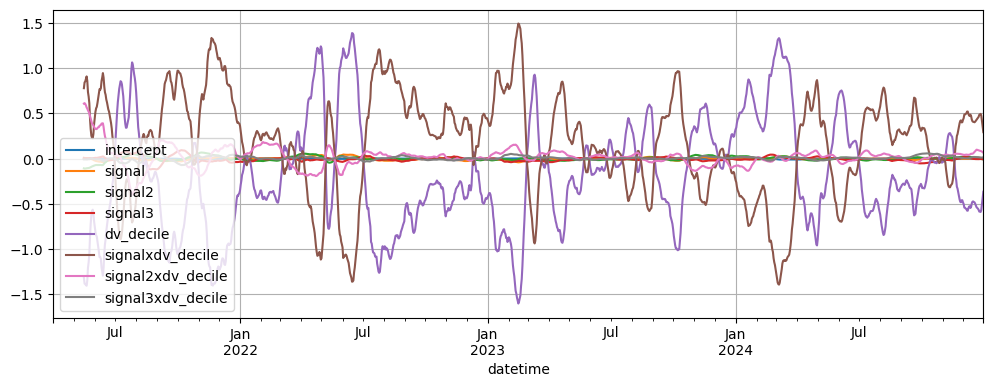

In [7]:
betas.plot(figsize=(12,4), grid=True)

# CV r2

Common Causes of negative CV r2

- Non-stationarity - The relationship between your features and target is changing over time
- Overfitting - Your model captures noise in training data that doesn't generalize
- Feature relevance issues - Some features might have temporary predictive power that doesn't persist
- Market regime changes - Financial relationships often change abruptly

Mean CV R²: 0.0152, Median CV R²: 0.0141


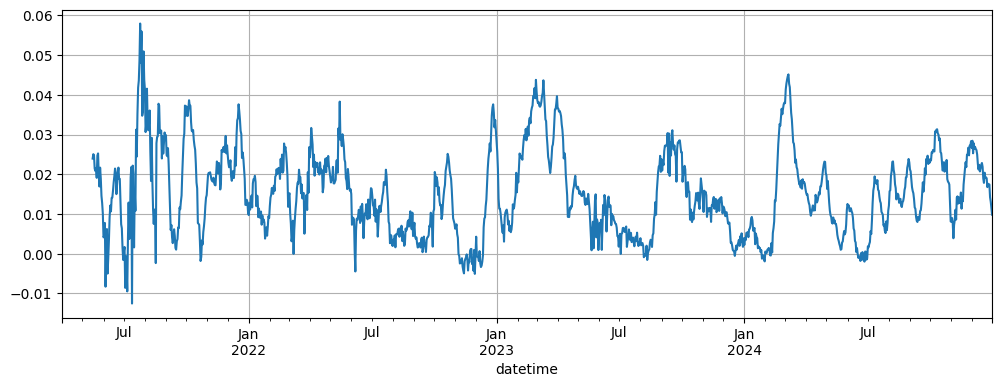

In [8]:
cv_r2.plot(figsize=(12,4), grid=True)

print(f"Mean CV R²: {cv_r2.mean():.4f}, Median CV R²: {cv_r2.median():.4f}")

Text(0.5, 1.0, 'VIF Over Time')

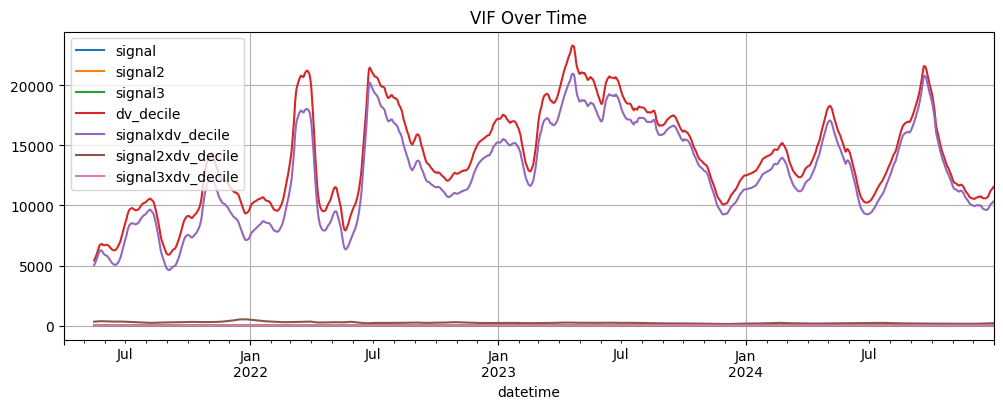

In [9]:
vif_df.plot(figsize=(12,4), grid=True)
plt.title("VIF Over Time")


In [10]:
# # Join forecasts back to original df
# df = df.merge(forecast.stack().rename('forecast'), left_on=['datetime', 'symbol'], right_index=True)

# Drop existing 'forecast' column from df to avoid conflicts
if 'forecast' in df.columns:
    df = df.drop(columns='forecast')

# Join forecasts back to original df
df = df.merge(forecast.stack().rename('forecast'), 
              left_on=['datetime', 'symbol'], 
              right_index=True, 
              how='left')

In [11]:
# Pivot for backtest inputs
def pivot_data(df: pd.DataFrame):
	forecast = df.pivot(index='datetime', columns='symbol', values='forecast')
	returns = df.pivot(index='datetime', columns='symbol', values='return')
	funding = df.pivot(index='datetime', columns='symbol', values='fundingRate')
	volatility = df.pivot(index='datetime', columns='symbol', values='volatility')

	return forecast, returns, funding, volatility

forecast, returns, funding, volatility = pivot_data(df)

In [12]:
def compute_weights(alpha_forecast: pd.DataFrame,
                    lag: bool = True,
                    inertia: float = 0.0,   # 0 ≤ inertia < 1
                    l2_shrink: float = 0.0  # ≥ 0, strength of shrinkage
                   ) -> pd.DataFrame:
    """
    Convert a cross-sectional alpha signal into dollar-neutral weights,
    with optional inertia and L2 shrinkage.

    Parameters
    ----------
    alpha_forecast : DataFrame  (index = timestamp, columns = symbol)
    lag            : bool       shift weights by one bar to avoid look-ahead
    inertia        : float      fraction of yesterday’s book to keep
                               0 → no decay (default)
                               0.6 → keep 60 % of prev. weights
    l2_shrink      : float      λ ≥ 0, shrinkage strength
                               0 → no shrinkage
                               larger → more pull toward 0
    """
    # 1) Demean signal
    adj = alpha_forecast.sub(alpha_forecast.mean(axis=1), axis=0)

    # 2) Dollar-neutral, |w| = 1
    weights_raw = adj.div(adj.abs().sum(axis=1), axis=0)

    # 3) Optional inertia
    if inertia:
        prev_w  = weights_raw.shift(1).fillna(0.0)
        weights = inertia * prev_w + (1 - inertia) * weights_raw
    else:
        weights = weights_raw

    # 4) Optional shrinkage: rescale toward 0
    if l2_shrink > 0:
        # Divide by (1 + λ) ⇒ simple ridge-like shrinkage
        weights = weights / (1.0 + l2_shrink)

    # 5) Optional lag
    if lag:
        weights = weights.shift(1)

    return weights.fillna(0.0)


weights = compute_weights(forecast, lag=True, inertia=0.25)
print(f"Turnover with inertia {weight_inertia}: {weights.diff().abs().sum(axis=1).mean():.4f} per day")
weights

Turnover with inertia 0: 0.1591 per day


symbol,1000BONK,1000FLOKI,1000LUNC,1000PEPE,1000RATS,1000SATS,1000SHIB,1000XEC,1INCH,1MBABYDOGE,...,XVS,YFI,YGG,ZEC,ZEN,ZETA,ZIL,ZK,ZRO,ZRX
datetime,,,,,,,,,,,,,,,,,,,,,
2021-04-01,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-02,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-03,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-04,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-04-05,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.0,0.0,0.0,0.0,0.0,-0.009146,0.0,0.0,0.001410,0.002992,...,0.001023,-0.001520,-0.002116,0.000829,0.008674,-0.002832,0.002230,-0.002117,0.000867,0.000927
2024-12-28,0.0,0.0,0.0,0.0,0.0,-0.008485,0.0,0.0,0.001288,0.002407,...,0.001282,-0.001907,-0.002119,-0.001411,0.007770,-0.003152,0.002028,-0.002699,-0.000189,0.000475
2024-12-29,0.0,0.0,0.0,0.0,0.0,-0.008228,0.0,0.0,0.001387,0.001686,...,0.001469,-0.002313,-0.002602,-0.002322,0.006516,-0.003452,0.001869,-0.002837,-0.001422,0.000479


<Axes: >

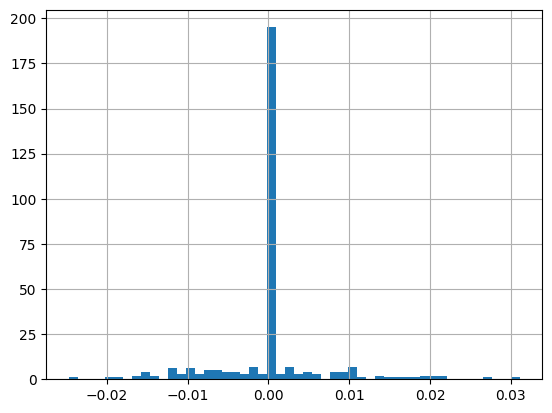

In [13]:
weights.iloc[-1000].sort_values().hist(bins=50)

In [14]:
def vol_target_weights(raw_w: pd.DataFrame,
					   rets:   pd.DataFrame,
					   vol_target_ann: float,   # 10 % annualised
					   lookback: int,        # trading days
					   min_obs:  int      = 90) -> pd.DataFrame:
	"""
	Scale each day's weight vector so that realised σ ≈ `vol_target_ann`
	when estimated with a Ledoit-Wolf covariance on the past `lookback` days.

	Parameters
	----------
	raw_w            : DataFrame (index = timestamp, columns = symbol)
					   *pre-leverage* weights (dollar-neutral & |w|=1 already)
	rets             : DataFrame, same shape/order as `raw_w`
	vol_target_ann   : float, annualised target volatility (e.g. 0.10 = 10 %)
	lookback         : int, size of rolling window (calendar rows) for Σ̂
	min_obs          : int, minimum obs to start scaling; before that w = raw_w

	Returns
	-------
	scaled_w         : DataFrame of leverage-adjusted weights
	"""
	# daily target σ
	tgt_daily = vol_target_ann / np.sqrt(365)

	scaled = []
	for t, w in raw_w.iterrows():
		# slice past window *strictly up to and excluding* t
		end_loc = rets.index.get_loc(t)
		win = rets.iloc[max(0, end_loc - lookback): end_loc]
		win = win.dropna(axis=1, how="all").ffill()    

		if len(win) < min_obs:
			scaled.append(w)                     # not enough history yet
			continue

		# print date and fitting widow
		print(f"Vol target on {t.date()} using window "
			  f"{win.index[0].date()} to {win.index[-1].date()} "
			  f"({len(win)} obs, {len(win.columns)} assets)")

		# drop cols that are all-nan in window to keep LedoitWolf happy
		win = win.loc[:, win.notna().any()]

		# if every weight is zero (all skipped universe) just keep it
		if np.allclose(w, 0):
			scaled.append(w.reindex(raw_w.columns).fillna(0))
			continue

		# Ledoit–Wolf shrinkage; fall back if sklearn missing
		lw = LedoitWolf().fit(win.fillna(0))
		Sigma = lw.covariance_
		Sigma = pd.DataFrame(Sigma, index=win.columns, columns=win.columns)

		# align Σ to full column set, fill missing with zeros
		Sigma = Sigma.reindex(index=raw_w.columns, columns=raw_w.columns).fillna(0)

		# portfolio variance and scaling factor
		var_p = np.dot(w.values, np.dot(Sigma.values, w.values))
		if var_p <= 0:
			scale = 0.0
		else:
			scale = tgt_daily / np.sqrt(var_p)

		scaled.append(w * scale)

	scaled_w = pd.DataFrame(scaled, index=raw_w.index).fillna(0.0)
	return scaled_w


weights_scaled = vol_target_weights(weights, returns,
								vol_target_ann=0.2,
								lookback=180)

Vol target on 2021-06-30 using window 2021-04-01 to 2021-06-29 (90 obs, 93 assets)
Vol target on 2021-07-01 using window 2021-04-01 to 2021-06-30 (91 obs, 93 assets)
Vol target on 2021-07-02 using window 2021-04-01 to 2021-07-01 (92 obs, 93 assets)
Vol target on 2021-07-03 using window 2021-04-01 to 2021-07-02 (93 obs, 93 assets)
Vol target on 2021-07-04 using window 2021-04-01 to 2021-07-03 (94 obs, 93 assets)
Vol target on 2021-07-05 using window 2021-04-01 to 2021-07-04 (95 obs, 93 assets)
Vol target on 2021-07-06 using window 2021-04-01 to 2021-07-05 (96 obs, 93 assets)
Vol target on 2021-07-07 using window 2021-04-01 to 2021-07-06 (97 obs, 93 assets)
Vol target on 2021-07-08 using window 2021-04-01 to 2021-07-07 (98 obs, 94 assets)
Vol target on 2021-07-09 using window 2021-04-01 to 2021-07-08 (99 obs, 94 assets)
Vol target on 2021-07-10 using window 2021-04-01 to 2021-07-09 (100 obs, 94 assets)
Vol target on 2021-07-11 using window 2021-04-01 to 2021-07-10 (101 obs, 95 assets)
Vo

In [15]:
# PnL and turnover calculation
def backtest(weights: pd.DataFrame,
			 returns: pd.DataFrame,
			 funding: pd.DataFrame,
			 cost_rate: float):
	weights = weights.fillna(0)
	return_pnl = (weights * returns).sum(axis=1)
	funding_pnl = -(weights * funding).sum(axis=1)
	total = return_pnl + funding_pnl
	turnover = weights.fillna(0).diff().abs().sum(axis=1)
	total_after_cost = total - cost_rate * turnover
	return return_pnl, funding_pnl, total_after_cost, turnover

rtn_pnl, fnd_pnl, tot_pnl_post_cost, turn = backtest(weights_scaled, returns, funding, trading_cost_rate)

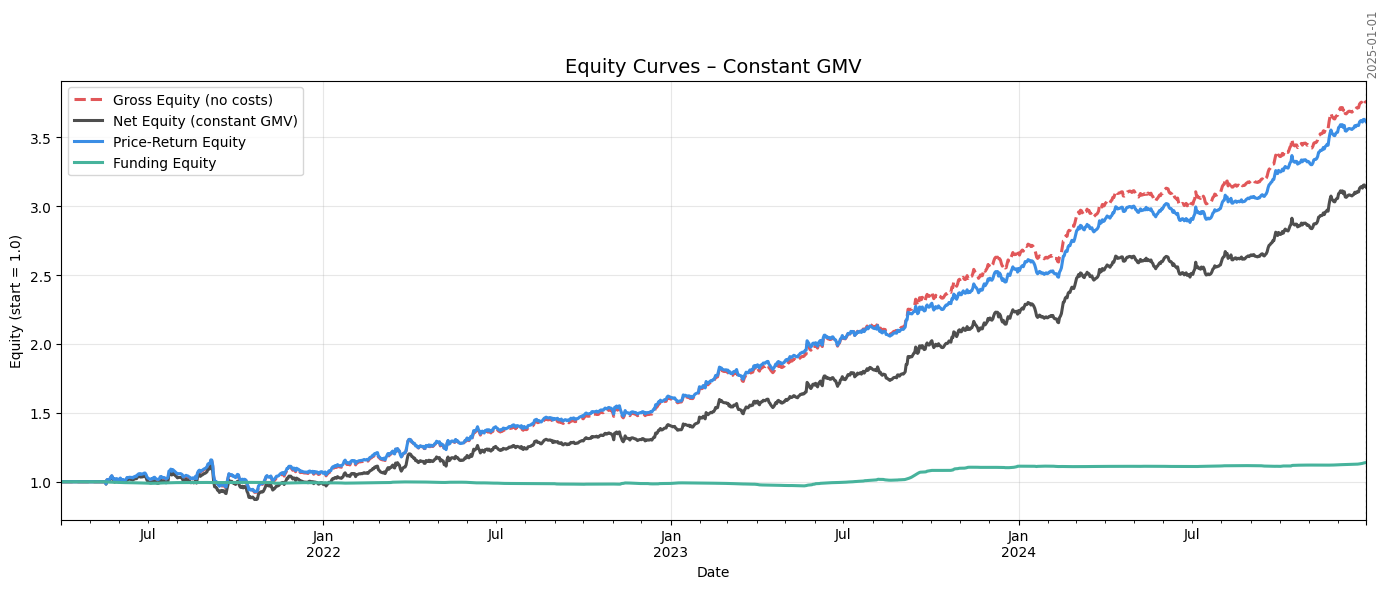

──────── Performance Summary ────────
CAGR:                           35.57%
Annualised volatility:           24.47%
Sharpe (ann.):                    2.32   95% CI [0.38, 4.27]
Max drawdown:                  -24.87%
──────── Execution / Cost ───────────
Avg daily turnover:             29.85%
Avg holding period:               3.35 days
Average annual cost drag:       -1634.12 bp


In [16]:
# ── Nicer-looking equity plot ────────────────────────────────────────────────
def plot_results(return_pnl, funding_pnl, total_after_cost, *, highlight_date="2025-01-01"):
	"""
	Plot four equity curves using a color‑blind‑friendly palette with a vertical
	reference line (default: 1 Jan 2025).

	Parameters
	----------
	return_pnl : pd.Series
		Daily price‑return P&L, indexed by date.
	funding_pnl : pd.Series
		Daily funding P&L, indexed by date.
	total_after_cost : pd.Series
		Daily total P&L after all costs, indexed by date.
	highlight_date : str or pd.Timestamp, optional
		Date at which to draw a dashed vertical reference line.  Pass ``None``
		to omit.
	"""

	# Build cumulative equity series (constant GMV, start = 1.0)
	gross_eq   = 1 + (return_pnl + funding_pnl).cumsum()
	total_eq   = 1 + total_after_cost.cumsum()
	return_eq  = 1 + return_pnl.cumsum()
	funding_eq = 1 + funding_pnl.cumsum()
	
	gross_eq.index = pd.to_datetime(gross_eq.index)
	total_eq.index = pd.to_datetime(total_eq.index)
	return_eq.index = pd.to_datetime(return_eq.index)
	funding_eq.index = pd.to_datetime(funding_eq.index)

	fig, ax = plt.subplots(figsize=(14, 6))

	# Color‑blind‑friendly hues (Okabe & Ito palette)
	palette = {
		"gross":   "#E15759",  # muted red
		"net":     "#4E4E4E",  # near‑black grey
		"return":  "#3B8EE5",  # blue
		"funding": "#47B39C",  # teal‑green
	}

	lw = 2.2  # consistent line thickness
	gross_eq.plot(ax=ax, label="Gross Equity (no costs)",   lw=lw, ls="--", color=palette["gross"])
	total_eq.plot(ax=ax, label="Net Equity (constant GMV)", lw=lw,            color=palette["net"])
	return_eq.plot(ax=ax, label="Price‑Return Equity",       lw=lw,            color=palette["return"])
	funding_eq.plot(ax=ax, label="Funding Equity",           lw=lw,            color=palette["funding"])

	# Optional vertical reference line
	if highlight_date is not None:
		highlight_date = pd.to_datetime(highlight_date)
		ax.axvline(highlight_date, lw=1.6, ls=":", color="#6F6F6F", alpha=0.85)
		# Annotate the line without cluttering the legend
		ax.text(highlight_date, ax.get_ylim()[1], highlight_date.strftime(" %Y-%m-%d"),
				va="bottom", ha="left", fontsize="small", color="#6F6F6F", rotation=90)

	ax.set_title("Equity Curves – Constant GMV", fontsize=14)
	ax.set_xlabel("Date")
	ax.set_ylabel("Equity (start = 1.0)")
	ax.legend()
	ax.grid(True, alpha=0.3)
	fig.tight_layout()
	plt.show()


# ── Expanded performance report ──────────────────────────────────────────────
def report_metrics(total_after_cost, return_pnl, turnover, cost_rate):
	"""
	Prints an extended performance summary.
	"""
	import numpy as np
	import pandas as pd

	# --- core statistics -----------------------------------------------------
	mu     = total_after_cost.mean()
	sigma  = return_pnl.std()
	sharpe = mu / sigma * np.sqrt(365)

	# 95 % CI on annualised Sharpe (Jobson & Korkie, 1981)
	n   = len(total_after_cost)
	se  = np.sqrt((1 + 0.5 * sharpe**2) * 365 / n)
	ci  = sharpe - 1.96 * se, sharpe + 1.96 * se

	# --- risk-adjusted extras -----------------------------------------------
	# annualised volatility
	vol_ann = sigma * np.sqrt(365) * 100

	# CAGR of the equity curve (constant-GMV arithmetic cum-P&L)
	equity_curve = 1 + total_after_cost.cumsum()
	cagr = equity_curve.iloc[-1]**(365 / n) - 1

	# max drawdown of cumulative P&L (not compounded)
	running_max = equity_curve.cummax()
	drawdown    = equity_curve - running_max
	max_dd      = drawdown.min()      # negative number

	# turnover & cost
	avg_turnover   = turnover.mean()
	avg_hold       = 1 / avg_turnover if avg_turnover else np.inf
	cost_pnl       = -cost_rate * turnover
	cost_drag_bps  = cost_pnl.mean() * 1e4* 365   # annual cost in bps

	# --- print nicely --------------------------------------------------------
	print("──────── Performance Summary ────────")
	print(f"CAGR:                          {cagr:7.2%}")
	print(f"Annualised volatility:         {vol_ann:7.2f}%")
	print(f"Sharpe (ann.):                 {sharpe:7.2f}   95% CI [{ci[0]:.2f}, {ci[1]:.2f}]")
	print(f"Max drawdown:                 {max_dd:8.2%}")
	print("──────── Execution / Cost ───────────")
	print(f"Avg daily turnover:            {avg_turnover:7.2%}")
	print(f"Avg holding period:            {avg_hold:7.2f} days")
	print(f"Average annual cost drag:       {cost_drag_bps:7.2f} bp")


plot_results(rtn_pnl, fnd_pnl, tot_pnl_post_cost)
report_metrics(tot_pnl_post_cost, rtn_pnl, turn, trading_cost_rate)